### Isolation Forest on the Scraped CBI Data

One way of determining "abnormal" auction sessions is to apply the Isolation Forest algorithm to the data. In this notebook, I run IForest on the "total for foreign accounts" and "total cash." 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

from sklearn import preprocessing
from sklearn.metrics import make_scorer, recall_score
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import IsolationForest

pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [2]:
# Read in data
auction_df = pd.read_csv('../data/processed/processed.csv')

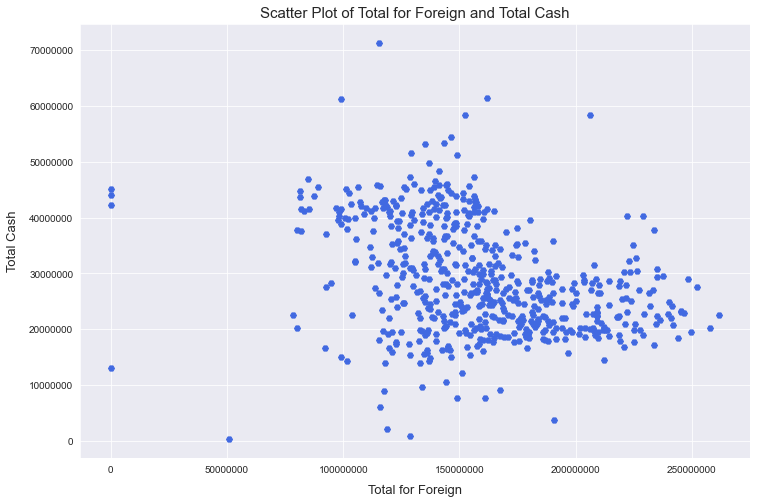

In [3]:
# Scatter plot to show distribution of the two amounts
plt.figure(figsize=(12,8))
plt.scatter(x=auction_df['total_for_foreign'], 
            y=auction_df['total_cash'],
            c='royalblue',marker='H'
           )
plt.xlabel('Total for Foreign',labelpad=10,fontsize=13)
plt.ylabel('Total Cash',labelpad=10,fontsize=13)
plt.ticklabel_format(useOffset=False, style='plain')
plt.title('Scatter Plot of Total for Foreign and Total Cash',fontsize=15)
plt.show()

Just from plotting there are a number of points that appear anomalous.

#### Isolation Forest

In [4]:
# Normalize the data
X = auction_df[['total_for_foreign','total_cash']].dropna()
X_norm = preprocessing.normalize(X)

In [5]:
# Fit the model
clf = IsolationForest(max_samples=100,random_state=42)
clf.fit(X)

IsolationForest(behaviour='deprecated', bootstrap=False, contamination='auto',
                max_features=1.0, max_samples=100, n_estimators=100,
                n_jobs=None, random_state=42, verbose=0, warm_start=False)

In [6]:
df = X.copy(deep=True)
df['anomaly_scores'] = clf.decision_function(X)
# Add anomaly scores to original dataframe
auction_df.loc[auction_df.index.isin(df.index),'anomaly_scores'] = df['anomaly_scores']

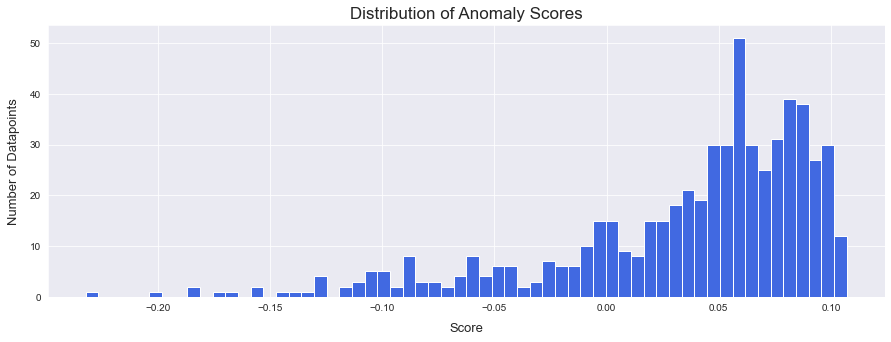

In [7]:
# Visualize distribution of anomaly scores
plt.figure(figsize=(15,5))
plt.hist(
    x=auction_df['anomaly_scores'].dropna(),
    bins=60,
    color='royalblue'
)
plt.title("Distribution of Anomaly Scores",fontsize=17)
plt.xlabel("Score",labelpad=10,fontsize=13)
plt.ylabel("Number of Datapoints",labelpad=10,fontsize=13)
# plt.savefig('../data/figures/anomaly_scores_distribution.png')
plt.show()

In [8]:
# Label the top 10th percentile of most anomalous datapoints
auction_df['most_anomalous'] = np.where(
    auction_df.anomaly_scores <= auction_df.anomaly_scores.quantile(.1),
    1,
    0
)

print(auction_df.most_anomalous.value_counts())

0    552
1     59
Name: most_anomalous, dtype: int64


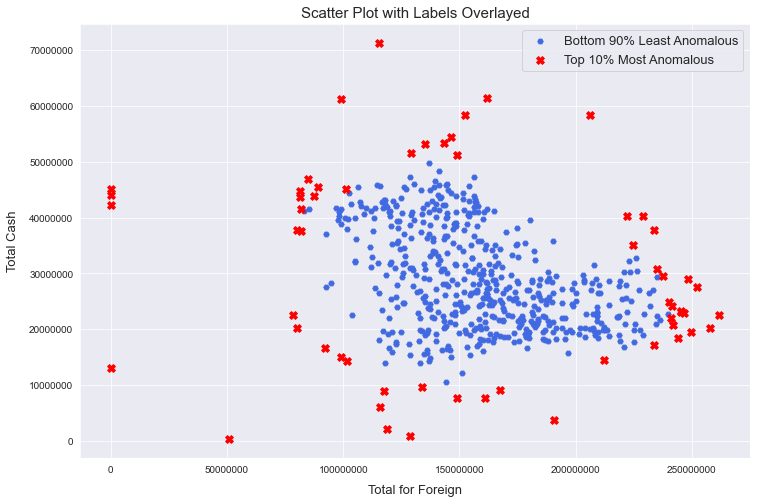

In [9]:
markers = ["H",'X']
sizes = [30, 60]
colors= ['royalblue','red']
plt.figure(figsize=(12,8))

for i in range(0,2):
    plt.scatter(
        auction_df[auction_df.most_anomalous==i]['total_for_foreign'], 
        auction_df[auction_df.most_anomalous==i]['total_cash'],
        s=sizes[i],
        marker=markers[i],
        c=colors[i]
    )
plt.title('Scatter Plot with Labels Overlayed',fontsize=15)
plt.xlabel('Total for Foreign',labelpad=10,fontsize=13)
plt.ylabel('Total Cash',labelpad=10,fontsize=13)
plt.legend(('Bottom 90% Least Anomalous','Top 10% Most Anomalous'), loc='upper right',fontsize=13)
plt.ticklabel_format(useOffset=False, style='plain')

# plt.savefig('../data/figures/top_10_pct_anomaly_scores.png')
plt.show()

In [10]:
auction_df.sort_values(by='anomaly_scores')[:20]

,date,total_for_foreign,total_cash,grand_total,exchange_rate,url,anomaly_scores,most_anomalous
585,تـاريخ البيع -,50799000.000,400000.000,51199000.000,سعر البيع النقدي (1190) دينارلكل دولار.,https://cbi.iq/currency_auction/view/723,-0.232,1
467,تـاريخ البيع - ليوم الأحد 2019/7/14 والمنفذ يو...,0.000,13140000.000,13140000.000,سعر البيع النقدي (1190) دينارلكل دولار.,https://cbi.iq/currency_auction/view/604,-0.201,1
38,تـاريخ البيع - الاحد 12-11-2017 والمنفذ يوم ال...,125.237,45190000.000,170426564.000,سعر بيع المبالغ المحولة لحسابات المصارف في الخ...,https://cbi.iq/currency_auction/view/163,-0.185,1
586,تـاريخ البيع -,206396558.000,58470000.000,264866558.000,سعر البيع النقدي (1190) دينارلكل دولار.,https://cbi.iq/currency_auction/view/724,-0.182,1
39,تـاريخ البيع - الاثنين 13-11-2017 والمنفذ يوم ...,117.653,44120000.000,161772579.000,سعر بيع المبالغ المحولة لحسابات المصارف في الخ...,https://cbi.iq/currency_auction/view/164,-0.171,1
80,تـاريخ البيع -,99269164.000,61230000.000,160499164.000,علماً أن :,https://cbi.iq/currency_auction/view/212,-0.169,1
40,تـاريخ البيع - الثلاثاء 14-11-2017 والمنفذ يوم...,119.606,42250000.000,161856286.000,سعر بيع المبالغ المحولة لحسابات المصارف في الخ...,https://cbi.iq/currency_auction/view/165,-0.157,1
148,تـاريخ البيع -,115279313.000,71260000.000,186539313.000,سعر بيع المبالغ المحولة لحسابات المصارف في الخ...,https://cbi.iq/currency_auction/view/281,-0.157,1
169,تـاريخ البيع -,161795403.000,61380000.000,223175403.000,علماً أن :,https://cbi.iq/currency_auction/view/302,-0.145,1
0,تـاريخ البيع - الثلاثاء 19-9-2017 والمنفذ يوم ...,118812407.000,2160000.000,162772407.000,سعر بيع المبالغ المحولة لحسابات المصارف في الخ...,https://cbi.iq/currency_auction/view/124,-0.140,1


In [12]:
auction_df[auction_df.total_for_foreign == auction_df.total_for_foreign.max()]

,date,total_for_foreign,total_cash,grand_total,exchange_rate,url,anomaly_scores,most_anomalous
509,تـاريخ البيع - ليوم الأربعاء 2019/9/18 والمنفذ...,261901361.000,22480000.000,284381361.000,سعر البيع النقدي (1190) دينارلكل دولار.,https://cbi.iq/currency_auction/view/646,-0.112,1
